## Important notes:

surface level Ozone is reported in parts per million

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary


In [2]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

Cuda installed! Running on GPU!
Device: cuda


In [3]:
# Importing the main meteorological data

traindata = pd.read_csv('./Data/pr_temp_wind_2018_2022_Bos.csv', sep=',')


In [4]:
# Importing all other feature data

traindata_SO2_2018 = pd.read_csv('./Data/SO2_daily_2018.csv', sep=',')
traindata_SO2_2019 = pd.read_csv('./Data/SO2_daily_2019.csv', sep=',')
traindata_SO2_2020 = pd.read_csv('./Data/SO2_daily_2020.csv', sep=',')
traindata_SO2_2021 = pd.read_csv('./Data/SO2_daily_2021.csv', sep=',')

traindata_CO_2018 = pd.read_csv('./Data/CO_daily_2018.csv', sep=',')
traindata_CO_2019 = pd.read_csv('./Data/CO_daily_2019.csv', sep=',')
traindata_CO_2020 = pd.read_csv('./Data/CO_daily_2020.csv', sep=',')
traindata_CO_2021 = pd.read_csv('./Data/CO_daily_2021.csv', sep=',')

traindata_NO2_2018 = pd.read_csv('./Data/NO2_daily_2018.csv', sep=',')
traindata_NO2_2019 = pd.read_csv('./Data/NO2_daily_2019.csv', sep=',')
traindata_NO2_2020 = pd.read_csv('./Data/NO2_daily_2020.csv', sep=',')
traindata_NO2_2021 = pd.read_csv('./Data/NO2_daily_2021.csv', sep=',')

/tmp/ipykernel_318/3207368089.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_SO2_2018 = pd.read_csv('./Data/SO2_daily_2018.csv', sep=',')
/tmp/ipykernel_318/3207368089.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_SO2_2019 = pd.read_csv('./Data/SO2_daily_2019.csv', sep=',')
/tmp/ipykernel_318/3207368089.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_SO2_2020 = pd.read_csv('./Data/SO2_daily_2020.csv', sep=',')
/tmp/ipykernel_318/3207368089.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_SO2_2021 = pd.read_csv('./Data/SO2_daily_2021.csv', sep=',')
/tmp/ipykernel_318/3207368089.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_CO_2018 = p

In [5]:
traindata = traindata.dropna()

In [6]:
traindata

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,PRCP,TAVG,TMAX,TMIN
0,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/1/2018,7.3,0.0,-14.7,-10.5,-17.7
1,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/2/2018,5.7,0.0,-12.3,-7.1,-15.5
2,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/3/2018,4.2,0.0,-6.2,-1.6,-8.8
3,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/4/2018,10.1,34.3,-3.6,-1.0,-5.5
4,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/5/2018,11.1,0.0,-7.8,-4.3,-14.3
...,...,...,...,...,...,...,...,...,...,...,...
1821,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,12/27/2022,4.5,0.0,-0.7,2.2,-2.1
1822,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,12/28/2022,3.8,0.0,0.2,6.1,-4.3
1823,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,12/29/2022,3.4,0.0,4.9,12.2,0.0
1824,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,12/30/2022,3.9,0.0,9.1,17.2,3.9


In [7]:
# Importing target data
target_data_2021 = pd.read_csv('./Data/ozone_daily_2021.csv', sep=',')
target_data_2020 = pd.read_csv('./Data/ozone_daily_2020.csv', sep=',')
target_data_2019 = pd.read_csv('./Data/ozone_daily_2019.csv', sep=',')
target_data_2018 = pd.read_csv('./Data/ozone_daily_2018.csv', sep=',')

/tmp/ipykernel_318/2871470904.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  target_data_2021 = pd.read_csv('./Data/ozone_daily_2021.csv', sep=',')
/tmp/ipykernel_318/2871470904.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  target_data_2020 = pd.read_csv('./Data/ozone_daily_2020.csv', sep=',')
/tmp/ipykernel_318/2871470904.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  target_data_2019 = pd.read_csv('./Data/ozone_daily_2019.csv', sep=',')
/tmp/ipykernel_318/2871470904.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  target_data_2018 = pd.read_csv('./Data/ozone_daily_2018.csv', sep=',')


In [8]:
#mask = target_data["City Name"]

In [9]:
# for i in range(len(mask)):
#     if mask[i] != "Lynn":
#         mask = mask.drop([i])

In [10]:
# Masks
target_mask = target_data_2018["City Name"] == "Lynn"
SO2_mask = traindata_SO2_2018["City Name"] == "Boston"
NO2_mask = traindata_NO2_2018["City Name"] == "Lynn"
#CO_mask = traindata_CO_2018["City Name"] == "Boston"

In [11]:
target_data_Lynn_2021 = target_data_2021.loc[target_mask]
target_data_Lynn_2020 = target_data_2020.loc[target_mask]
target_data_Lynn_2019 = target_data_2019.loc[target_mask]
target_data_Lynn_2018 = target_data_2018.loc[target_mask]

In [12]:
target_data_Lynn_2018

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
198887,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,37,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
198888,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,13,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
198889,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,36,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
198890,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,34,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
198891,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,36,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199246,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
199247,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,25,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
199248,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
199249,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,27,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04


In [13]:
traindata_SO2_Lynn_2021 = traindata_SO2_2021.loc[traindata_SO2_2021["City Name"] == "Boston"]
traindata_SO2_Lynn_2020 = traindata_SO2_2020.loc[traindata_SO2_2020["City Name"] == "Boston"]
traindata_SO2_Lynn_2019 = traindata_SO2_2019.loc[traindata_SO2_2019["City Name"] == "Boston"]
traindata_SO2_Lynn_2018 = traindata_SO2_2018.loc[SO2_mask]

traindata_SO2_Lynn_2021 = traindata_SO2_Lynn_2021.loc[traindata_SO2_Lynn_2021["Sample Duration"] == "1 HOUR"]
traindata_SO2_Lynn_2020 = traindata_SO2_Lynn_2020.loc[traindata_SO2_Lynn_2020["Sample Duration"] == "1 HOUR"]
traindata_SO2_Lynn_2019 = traindata_SO2_Lynn_2019.loc[traindata_SO2_Lynn_2019["Sample Duration"] == "1 HOUR"]
traindata_SO2_Lynn_2018 = traindata_SO2_Lynn_2018.loc[traindata_SO2_Lynn_2018["Sample Duration"] == "1 HOUR"]

traindata_SO2_Lynn_2021 = traindata_SO2_Lynn_2021.loc[traindata_SO2_Lynn_2021["Address"] == "KENMORE SQ"]
traindata_SO2_Lynn_2020 = traindata_SO2_Lynn_2020.loc[traindata_SO2_Lynn_2020["Address"] == "KENMORE SQ"]
traindata_SO2_Lynn_2019 = traindata_SO2_Lynn_2019.loc[traindata_SO2_Lynn_2019["Address"] == "KENMORE SQ"]
traindata_SO2_Lynn_2018 = traindata_SO2_Lynn_2018.loc[traindata_SO2_Lynn_2018["Address"] == "KENMORE SQ"]

In [14]:
traindata_SO2_Lynn_2018

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
129074,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,1.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129075,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,1.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129076,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,3.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129077,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,4.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129078,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,1.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129431,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,0.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129432,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,0.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129433,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,0.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129434,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,0.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04


In [15]:
traindata_CO_Lynn_2021 = traindata_CO_2021.loc[traindata_CO_2021["City Name"] == "Boston"]
traindata_CO_Lynn_2020 = traindata_CO_2020.loc[traindata_CO_2020["City Name"] == "Boston"]
traindata_CO_Lynn_2019 = traindata_CO_2019.loc[traindata_CO_2019["City Name"] == "Boston"]
traindata_CO_Lynn_2018 = traindata_CO_2018.loc[traindata_CO_2018["City Name"] == "Boston"]

# CO_mask2 = traindata_CO_Lynn_2018["Sample Duration"] == "1 HOUR"

traindata_CO_Lynn_2021 = traindata_CO_Lynn_2021.loc[traindata_CO_Lynn_2021["Sample Duration"] == "1 HOUR"]
traindata_CO_Lynn_2020 = traindata_CO_Lynn_2020.loc[traindata_CO_Lynn_2020["Sample Duration"] == "1 HOUR"]
traindata_CO_Lynn_2019 = traindata_CO_Lynn_2019.loc[traindata_CO_Lynn_2019["Sample Duration"] == "1 HOUR"]
traindata_CO_Lynn_2018 = traindata_CO_Lynn_2018.loc[traindata_CO_Lynn_2018["Sample Duration"] == "1 HOUR"]

traindata_CO_Lynn_2021 = traindata_CO_Lynn_2021.loc[traindata_CO_Lynn_2021["Address"] == "HARRISON AVE"]
traindata_CO_Lynn_2020 = traindata_CO_Lynn_2020.loc[traindata_CO_Lynn_2020["Address"] == "HARRISON AVE"]
traindata_CO_Lynn_2019 = traindata_CO_Lynn_2019.loc[traindata_CO_Lynn_2019["Address"] == "HARRISON AVE"]
traindata_CO_Lynn_2018 = traindata_CO_Lynn_2018.loc[traindata_CO_Lynn_2018["Address"] == "HARRISON AVE"]

In [16]:
traindata_CO_Lynn_2021

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
86507,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86508,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86509,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86510,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86511,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86860,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86861,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86862,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86863,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24


In [17]:
traindata_NO2_Lynn_2021 = traindata_NO2_2021.loc[traindata_NO2_2021["City Name"] == "Lynn"]
traindata_NO2_Lynn_2020 = traindata_NO2_2020.loc[traindata_NO2_2020["City Name"] == "Lynn"]
traindata_NO2_Lynn_2019 = traindata_NO2_2019.loc[traindata_NO2_2019["City Name"] == "Lynn"]
traindata_NO2_Lynn_2018 = traindata_NO2_2018.loc[NO2_mask]

In [18]:
traindata_NO2_Lynn_2018

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
69768,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,7,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
69769,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,19,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
69770,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,34,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
69771,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,30,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
69772,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,2,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70127,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,16,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
70128,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,25,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
70129,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,21,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
70130,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,33,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04


In [19]:
# Dropping the unneeded cols

dropped_cols = ['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change']

target_data_Lynn_2021 = target_data_Lynn_2021.drop(dropped_cols, axis=1)
target_data_Lynn_2020 = target_data_Lynn_2020.drop(dropped_cols, axis=1)
target_data_Lynn_2019 = target_data_Lynn_2019.drop(dropped_cols, axis=1)
target_data_Lynn_2018 = target_data_Lynn_2018.drop(dropped_cols, axis=1)

traindata_SO2_Lynn_2021 = traindata_SO2_Lynn_2021.drop(dropped_cols, axis=1)
traindata_SO2_Lynn_2020 = traindata_SO2_Lynn_2020.drop(dropped_cols, axis=1)
traindata_SO2_Lynn_2019 = traindata_SO2_Lynn_2019.drop(dropped_cols, axis=1)
traindata_SO2_Lynn_2018 = traindata_SO2_Lynn_2018.drop(dropped_cols, axis=1)

traindata_CO_Lynn_2021 = traindata_CO_Lynn_2021.drop(dropped_cols, axis=1)
traindata_CO_Lynn_2020 = traindata_CO_Lynn_2020.drop(dropped_cols, axis=1)
traindata_CO_Lynn_2019 = traindata_CO_Lynn_2019.drop(dropped_cols, axis=1)
traindata_CO_Lynn_2018 = traindata_CO_Lynn_2018.drop(dropped_cols, axis=1)

traindata_NO2_Lynn_2021 = traindata_NO2_Lynn_2021.drop(dropped_cols, axis=1)
traindata_NO2_Lynn_2020 = traindata_NO2_Lynn_2020.drop(dropped_cols, axis=1)
traindata_NO2_Lynn_2019 = traindata_NO2_Lynn_2019.drop(dropped_cols, axis=1)
traindata_NO2_Lynn_2018 = traindata_NO2_Lynn_2018.drop(dropped_cols, axis=1)

In [20]:
traindata_SO2_Lynn_2021

,Date Local,Arithmetic Mean
114582,2021-01-01,-0.323810
114583,2021-01-02,-0.279167
114584,2021-01-03,-0.275000
114585,2021-01-04,-0.214286
114586,2021-01-05,-0.279167
...,...,...
114942,2021-12-27,-0.057143
114943,2021-12-28,0.108333
114944,2021-12-29,0.050000
114945,2021-12-30,0.228571


In [21]:
# Adding all 4 years into 1 dataset
target_data = pd.concat([target_data_Lynn_2018, target_data_Lynn_2019, target_data_Lynn_2020, target_data_Lynn_2021], ignore_index=True)
target_data = target_data.rename(columns={"Arithmetic Mean": "ozone"})


traindata_SO2 = pd.concat([traindata_SO2_Lynn_2018, traindata_SO2_Lynn_2019, traindata_SO2_Lynn_2020, traindata_SO2_Lynn_2021], ignore_index=True)
traindata_SO2 = traindata_SO2.rename(columns={"Arithmetic Mean": "SO2"})


traindata_CO = pd.concat([traindata_CO_Lynn_2018, traindata_CO_Lynn_2019, traindata_CO_Lynn_2020, traindata_CO_Lynn_2021], ignore_index=True)
traindata_CO = traindata_CO.rename(columns={"Arithmetic Mean": "CO"})


traindata_NO2 = pd.concat([traindata_NO2_Lynn_2018, traindata_NO2_Lynn_2019, traindata_NO2_Lynn_2020, traindata_NO2_Lynn_2021], ignore_index=True)
traindata_NO2 = traindata_NO2.rename(columns={"Arithmetic Mean": "NO2"})

In [22]:
# Reformating and renaming the DATE column in the main traindata set

target_data["Date Local"] = pd.to_datetime(target_data["Date Local"])
traindata_SO2["Date Local"] = pd.to_datetime(traindata_SO2["Date Local"])
traindata_CO["Date Local"] = pd.to_datetime(traindata_CO["Date Local"])
traindata_NO2["Date Local"] = pd.to_datetime(traindata_NO2["Date Local"])

traindata["DATE"] = pd.to_datetime(traindata["DATE"])
traindata = traindata.rename(columns={"DATE": "Date Local"})

In [23]:
# Merging all together
dataset = pd.merge(target_data, traindata, on='Date Local').merge(traindata_SO2, on="Date Local").merge(traindata_CO, on="Date Local").merge(traindata_NO2, on="Date Local")

In [24]:
# dataset["ozone"] = dataset["ozone"] * 1000
# dataset

In [25]:
dataset.isna().sum()

Date Local    0
ozone         0
STATION       0
NAME          0
LATITUDE      0
LONGITUDE     0
ELEVATION     0
AWND          0
PRCP          0
TAVG          0
TMAX          0
TMIN          0
SO2           0
CO            0
NO2           0
dtype: int64

In [26]:
dataset.columns

Index(['Date Local', 'ozone', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO',
       'NO2'],
      dtype='object')

In [27]:
useless_cols = ['Date Local', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']

dataset = dataset.drop(useless_cols, axis=1)

In [28]:
dataset

,ozone,AWND,PRCP,TAVG,TMAX,TMIN,SO2,CO,NO2
0,0.038583,7.3,0.0,-14.7,-10.5,-17.7,0.762500,0.175435,0.875000
1,0.007917,4.2,0.0,-6.2,-1.6,-8.8,1.995833,0.348053,18.750000
2,0.036176,10.1,34.3,-3.6,-1.0,-5.5,1.495833,0.265957,8.333333
3,0.035941,11.1,0.0,-7.8,-4.3,-14.3,0.923810,0.184636,0.545455
4,0.036824,9.8,0.0,-13.1,-11.0,-17.1,0.741667,0.165783,-0.041667
...,...,...,...,...,...,...,...,...,...
1607,0.038176,3.4,0.3,12.3,17.2,8.9,0.180952,0.311417,5.875000
1608,0.031706,5.2,0.0,16.7,24.4,10.6,0.245833,0.240684,3.845455
1609,0.037471,6.7,6.1,15.2,22.2,3.3,0.208333,0.194087,4.550000
1610,0.037235,9.0,0.0,5.3,8.3,1.1,0.166667,0.155955,1.175000


## Segmenting the data into (train, valid, test)

In [29]:
# I want 95% for training purposes; 2.5% valid, 2.5% test

train, test = train_test_split(dataset, test_size=0.05, shuffle=False)

valid, test = train_test_split(test, test_size=.5, shuffle=False)

In [30]:
train.columns

Index(['ozone', 'AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO', 'NO2'], dtype='object')

In [31]:
# splitting into features and output

train_features = train.drop("ozone", axis=1)
train_output = train.drop(['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO', 'NO2'], axis=1)

valid_features = valid.drop("ozone", axis=1)
valid_output = valid.drop(['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO', 'NO2'], axis=1)

test_features = test.drop("ozone", axis=1)
test_output = test.drop(['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO', 'NO2'], axis=1)

In [32]:
# Scaling pre-processing
scaler = StandardScaler()
scaler.fit(train_features)

# Define Train Set
X_train = torch.from_numpy(scaler.transform(train_features.values)).float()
y_train = torch.from_numpy(train_output.values).float()
train_dataset = TensorDataset(X_train, y_train)

# Define Valid Set
X_valid = torch.from_numpy(scaler.transform(valid_features.values)).float()
y_valid = torch.from_numpy(valid_output.values).float()
valid_dataset = TensorDataset(X_valid, y_valid)


# Define Test Set
X_test = torch.from_numpy(scaler.transform(test_features.values)).float()
y_test = torch.from_numpy(test_output.values).float()
test_dataset = TensorDataset(X_test, y_test)

# Use Pytorch's functionality to load data in batches.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # shape [batch_size=256, features=17, output=1]
valid_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [33]:
len(X_valid)

40

## Defining the neural network

In [34]:
# define 4 layer NN

class NeuralNetwork(torch.nn.Module):
     def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.activation1 = torch.nn.LeakyReLU(negative_slope=0.1, inplace=False)
        self.dropout = nn.Dropout(p=0.5)
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size//2)
        self.activation2 = torch.nn.LeakyReLU(negative_slope=0.1, inplace=False)
        self.linear3 = torch.nn.Linear(hidden_size//2, hidden_size//4)
        self.activation3 = torch.nn.LeakyReLU(negative_slope=0.1, inplace=False)
        self.linear4 = torch.nn.Linear(hidden_size//4, output_size)
        
     def forward(self, x):
        x=self.linear1(x)       #Order of operations (apply linear, apply activation, apply linear again, then return the tensor
        x=self.activation1(x)
        x=self.dropout(x)
        x=self.linear2(x)
        x=self.activation2(x)
        x=self.dropout(x)
        x=self.linear3(x)
        x=self.activation3(x)
        x=self.dropout(x)
        x=self.linear4(x)
        return x
    
    

In [35]:
# define 2 layer NN

class NeuralNetwork_Smol(torch.nn.Module):
     def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork_Smol, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.activation1 = torch.nn.LeakyReLU(negative_slope=0.1, inplace=False)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        self.activation2 = torch.nn.ReLU(inplace=False)
        
     def forward(self, x):
        x=self.linear1(x)       #Order of operations (apply linear, apply activation, apply linear again, then return the tensor
        x=self.activation1(x)
        x=self.linear2(x)
        x=self.activation2(x)
        return x

In [36]:
#train and optimization for small network

neural_model_smol=NeuralNetwork_Smol(input_size=8, hidden_size=64, output_size=1)  #empty model waiting for data
neural_model_smol.to(device)
criterion=torch.nn.MSELoss()      #Pulls class from Super.__init__ from torch.nn.Module
optimizer=torch.optim.Adam(neural_model_smol.parameters(), lr=0.001)    # adding L2 regulization strength of 0.01

best_loss = float('inf')

steps = []
Train_loss = []     #     FOR PLOTTING PURPOSES

for epoch in range(250):
    for data in train_loader:
        data[0] = data[0].to(device)
        data[1] = data[1].to(device)

        #forward 
        outputs=neural_model_smol(data[0])
        outputs = outputs.squeeze(1)
        # print(outputs, data[1].float())
        loss=criterion(outputs, data[1])   #comparing loss from output to target
    
        #backward and optimization 
        optimizer.zero_grad()   #ORder of opetations
        loss.backward()
        optimizer.step()
    steps.append(epoch)
    Train_loss.append(loss.cpu().detach().numpy().copy())                   #      FOR PLOTTING PURPOSES   loss.item?
    
    
    print("epoch {}, loss function {}".format(epoch, loss.item()))
    # a good MSE Loss is usually 1  Aka. 0.something
    if loss.item() < best_loss:
        # save network
        torch.save(neural_model_smol.state_dict(), "best_model_Smol_ReLU.pth")
        best_loss = loss.item()

/srv/conda/envs/notebook/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/srv/conda/envs/notebook/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([27, 1])) that is different to the input size (torch.Size([27])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss function 0.0009704181575216353
epoch 1, loss function 0.0009171972633339465
epoch 2, loss function 0.0009190607815980911
epoch 3, loss function 0.0009204185334965587
epoch 4, loss function 0.0009193572332151234
epoch 5, loss function 0.0009173942962661386
epoch 6, loss function 0.0009154219296760857
epoch 7, loss function 0.000913235533516854
epoch 8, loss function 0.0009115051943808794
epoch 9, loss function 0.0009105029166676104
epoch 10, loss function 0.0009100140887312591
epoch 11, loss function 0.0009103645570576191
epoch 12, loss function 0.0009138297755271196
epoch 13, loss function 0.0009145484655164182
epoch 14, loss function 0.0009108854574151337
epoch 15, loss function 0.0009408989571966231
epoch 16, loss function 0.0009408989571966231
epoch 17, loss function 0.0009408989571966231
epoch 18, loss function 0.0009408989571966231
epoch 19, loss function 0.0009408989571966231
epoch 20, loss function 0.0009408989571966231
epoch 21, loss function 0.0009408989571966231

Text(0, 0.5, 'Train Loss')

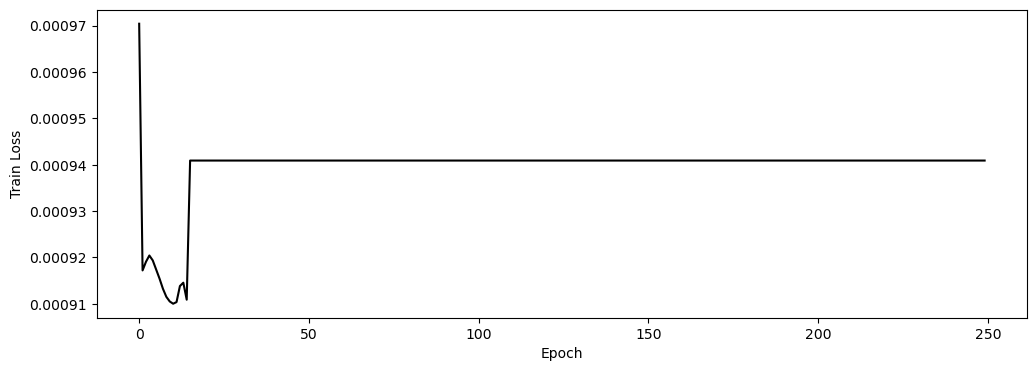

In [37]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(Train_loss, 'k')
ax.set_xlabel("Epoch")
ax.set_ylabel("Train Loss")

In [38]:
# Load the saved state dictionary
state_dict = torch.load('best_model_Smol_ReLU.pth')

# Print the keys and shapes of the parameters in the state dictionary
for key, value in state_dict.items():
    print(key, value.shape)


linear1.weight torch.Size([64, 8])
linear1.bias torch.Size([64])
linear2.weight torch.Size([1, 64])
linear2.bias torch.Size([1])


In [39]:
# Validation for smol
model = NeuralNetwork_Smol(input_size=8, hidden_size=64, output_size=1)
model.load_state_dict(torch.load('best_model_Smol_ReLU.pth'))

# Define the loss function
criterion = nn.MSELoss()

# Initialize variables for tracking the validation loss
valid_losses = []

# Calculate the validation loss for each batch of validation data
with torch.no_grad():
    for batch_x, batch_y in valid_loader:
        y_pred = model(batch_x)
        loss = criterion(y_pred, batch_y)
        valid_losses.append(loss.item())

# Calculate the average validation loss
avg_valid_loss = np.mean(valid_losses)

y_true = y_valid

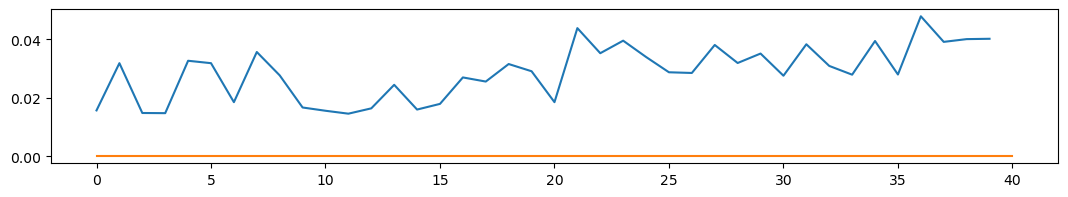

In [40]:
# Looking at the predictions vs true values for validation purposes

plt.figure(figsize=(13, 2))
plt.plot(y_true)
plt.plot(y_pred)

In [41]:
# Testing the model for smol

# Load saved model
model = NeuralNetwork_Smol(input_size=8, hidden_size=64, output_size=1)
model.load_state_dict(torch.load('best_model_Smol_ReLU.pth'))


# Evaluate the model
model.eval()
y_preds = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        y_pred = model(batch_x)
        y_preds.append(y_pred.numpy())

# Compute the evaluation metrics

y_pred = np.concatenate(y_preds, axis=0)
y_true = y_test



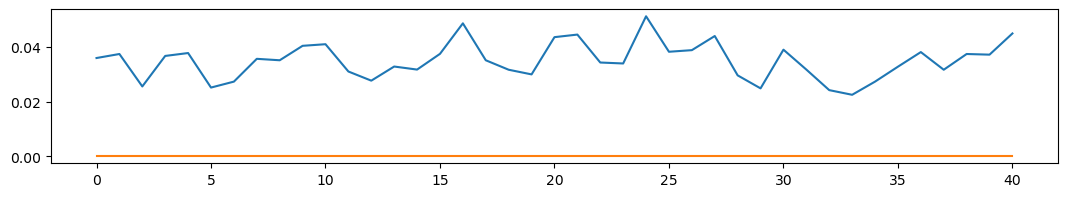

In [42]:
# Looking at the predictions vs true values for testing the model

plt.figure(figsize=(13, 2))
plt.plot(y_true)
plt.plot(y_pred)

In [43]:
# #train and optimization for 4 layers

# neural_model=NeuralNetwork(input_size=8, hidden_size=64, output_size=1)  #empty model waiting for data
# neural_model.to(device)
# criterion=torch.nn.MSELoss()      #Pulls class from Super.__init__ from torch.nn.Module
# optimizer=torch.optim.Adam(neural_model.parameters(), lr=0.001)    # adding L2 regulization strength of 0.01

# best_loss = float('inf')

# steps = []
# Train_loss = []     #     FOR PLOTTING PURPOSES

# for epoch in range(250):
#     for data in train_loader:
#         data[0] = data[0].to(device)
#         data[1] = data[1].to(device)

#         #forward 
#         outputs=neural_model(data[0])
#         outputs = outputs.squeeze(1)
#         # print(outputs, data[1].float())
#         loss=criterion(outputs, data[1])   #comparing loss from output to target
    
#         #backward and optimization 
#         optimizer.zero_grad()   #ORder of opetations
#         loss.backward()
#         optimizer.step()
#     steps.append(epoch)
#     Train_loss.append(loss.cpu().detach().numpy().copy())                   #      FOR PLOTTING PURPOSES   loss.item?
    
    
#     print("epoch {}, loss function {}".format(epoch, loss.item()))
#     # a good MSE Loss is usually 1  Aka. 0.something
#     if loss.item() < best_loss:
#         # save network
#         torch.save(neural_model.state_dict(), "best_model.pth")
#         best_loss = loss.item()

In [44]:
# # Validation

# # Load saved model
# model = NeuralNetwork(input_size=8, hidden_size=32, output_size=1)
# model.load_state_dict(torch.load('best_model.pth'))

# # Validate the model
# model.eval()
# y_preds = []
# with torch.no_grad():
#     for batch_x, batch_y in valid_loader:
#         y_pred = model(batch_x)
#         y_preds.append(y_pred.numpy())

# # Compute the evaluation metrics

# y_pred = np.concatenate(y_preds, axis=0)
# y_true = y_valid



In [45]:
# # Load saved model
# model = NeuralNetwork(input_size=8, hidden_size=64, output_size=1)
# model.load_state_dict(torch.load('best_model.pth'))

# # Define the loss function
# criterion = nn.MSELoss()

# # Initialize variables for tracking the validation loss
# valid_losses = []

# # Calculate the validation loss for each batch of validation data
# with torch.no_grad():
#     for batch_x, batch_y in valid_loader:
#         y_pred = model(batch_x)
#         loss = criterion(y_pred, batch_y)
#         valid_losses.append(loss.item())

# # Calculate the average validation loss
# avg_valid_loss = np.mean(valid_losses)

# y_true = y_valid

In [46]:
# # Print the average validation loss
# print(f"Average Validation Loss: {avg_valid_loss:.4f}")

# # Plot the validation loss values
# plt.plot(valid_losses)
# plt.xlabel('Batch')
# plt.ylabel('Validation Loss')
# plt.show()

In [47]:
# # Looking at the predictions vs true values for validation purposes

# plt.figure(figsize=(13, 2))
# plt.plot(y_true)
# plt.plot(y_pred)

In [48]:
# # Testing the model

# # Load saved model
# model = NeuralNetwork(input_size=8, hidden_size=32, output_size=1)
# model.load_state_dict(torch.load('best_model.pth'))


# # Evaluate the model
# model.eval()
# y_preds = []
# with torch.no_grad():
#     for batch_x, batch_y in test_loader:
#         y_pred = model(batch_x)
#         y_preds.append(y_pred.numpy())

# # Compute the evaluation metrics

# y_pred = np.concatenate(y_preds, axis=0)
# y_true = y_test



In [49]:
# # Looking at the predictions vs true values for testing the model

# plt.figure(figsize=(13, 2))
# plt.plot(y_true)
# plt.plot(y_pred)

In [50]:
testing_error_mse = mean_squared_error(y_true, y_pred)
print("MSE: ", testing_error_mse)

MSE:  0.0012710288


## Questions:

- Do I need all units to be the same?  
No

- Is my MSE good? or is this because my ozone numbers are relatively small?   
normalize MSE

- Do I still need to do RNN even tho I am now only 1 person doing the project?  
I will still try to do it because I will learn better abt the architecture and how to build it, but in case I could not figure it out quickly, I still need to find a paper and read it.  






## Predicting Ozone pollution in different cities

In [51]:
# Importing the main meteorological data

pr_temp_wind = pd.read_csv('./Data/Jacksonville.csv', sep=',')


In [52]:
pr_temp_wind = pr_temp_wind.dropna()
pr_temp_wind

,STATION,DATE,AWND,PRCP,TAVG,TMAX,TMIN
0,USW00013889,2018-01-01,6.4,4.1,5.6,8.3,2.2
1,USW00013889,2018-01-02,6.6,0.0,1.9,5.0,-0.5
2,USW00013889,2018-01-03,4.8,20.6,2.1,5.0,-1.0
3,USW00013889,2018-01-04,4.7,0.0,2.0,8.3,-2.1
4,USW00013889,2018-01-05,2.6,0.0,2.5,9.4,-2.1
...,...,...,...,...,...,...,...
1456,USW00013889,2021-12-27,2.6,0.0,17.7,24.4,13.9
1457,USW00013889,2021-12-28,1.3,0.0,17.6,26.7,11.7
1458,USW00013889,2021-12-29,3.2,0.0,18.6,27.8,11.7
1459,USW00013889,2021-12-30,3.2,0.0,20.9,27.8,15.0


https://www.ncei.noaa.gov/access/search/data-search/daily-summaries?bbox=30.883,-98.852,29.529,-96.526&startDate=2018-01-01T00:00:00&endDate=2021-12-31T23:59:59&dataTypes=AWND&dataTypes=PRCP&dataTypes=TAVG&dataTypes=TMAX&dataTypes=TMIN


No Average temperature 

In [53]:
target_data_Florida_2021 = target_data_2021.loc[target_data_2021["City Name"] == "Jacksonville"]
target_data_Florida_2020 = target_data_2020.loc[target_data_2020["City Name"] == "Jacksonville"]
target_data_Florida_2019 = target_data_2019.loc[target_data_2019["City Name"] == "Jacksonville"]
target_data_Florida_2018 = target_data_2018.loc[target_data_2018["City Name"] == "Jacksonville"]

In [54]:
target_data_Florida_2018

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
112049,12,31,77,44201,1,30.477725,-81.587339,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,29,NaN,-,Sheffield,13333 LANIER RD.,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
112050,12,31,77,44201,1,30.477725,-81.587339,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,30,NaN,-,Sheffield,13333 LANIER RD.,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
112051,12,31,77,44201,1,30.477725,-81.587339,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,27,NaN,-,Sheffield,13333 LANIER RD.,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
112052,12,31,77,44201,1,30.477725,-81.587339,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,Sheffield,13333 LANIER RD.,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
112053,12,31,77,44201,1,30.477725,-81.587339,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,19,NaN,-,Sheffield,13333 LANIER RD.,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113131,12,31,106,44201,1,30.378217,-81.840900,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
113132,12,31,106,44201,1,30.378217,-81.840900,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,23,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
113133,12,31,106,44201,1,30.378217,-81.840900,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,15,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
113134,12,31,106,44201,1,30.378217,-81.840900,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,20,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03


In [55]:
target_data_Florida_2021 = target_data_Florida_2021.loc[target_data_2021["Local Site Name"] == "Cisco Drive"]
target_data_Florida_2020 = target_data_Florida_2020.loc[target_data_2020["Local Site Name"] == "Cisco Drive"]
target_data_Florida_2019 = target_data_Florida_2019.loc[target_data_2019["Local Site Name"] == "Cisco Drive"]
target_data_Florida_2018 = target_data_Florida_2018.loc[target_data_2018["Local Site Name"] == "Cisco Drive"]

In [56]:
target_data_Florida_2018

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
112771,12,31,106,44201,1,30.378217,-81.8409,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
112772,12,31,106,44201,1,30.378217,-81.8409,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,33,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
112773,12,31,106,44201,1,30.378217,-81.8409,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
112774,12,31,106,44201,1,30.378217,-81.8409,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,36,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
112775,12,31,106,44201,1,30.378217,-81.8409,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,34,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113131,12,31,106,44201,1,30.378217,-81.8409,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
113132,12,31,106,44201,1,30.378217,-81.8409,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,23,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
113133,12,31,106,44201,1,30.378217,-81.8409,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,15,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03
113134,12,31,106,44201,1,30.378217,-81.8409,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,20,NaN,-,Cisco Drive,4770 Cisco Dr,Florida,Duval,Jacksonville,"Jacksonville, FL",2021-11-03


In [57]:
traindata_SO2_Florida_2021 = traindata_SO2_2021.loc[traindata_SO2_2021["City Name"] == "Jacksonville"]
traindata_SO2_Florida_2020 = traindata_SO2_2020.loc[traindata_SO2_2020["City Name"] == "Jacksonville"]
traindata_SO2_Florida_2019 = traindata_SO2_2019.loc[traindata_SO2_2019["City Name"] == "Jacksonville"]
traindata_SO2_Florida_2018 = traindata_SO2_2018.loc[traindata_SO2_2018["City Name"] == "Jacksonville"]

traindata_SO2_Florida_2021 = traindata_SO2_Florida_2021.loc[traindata_SO2_Florida_2021["Sample Duration"] == "1 HOUR"]
traindata_SO2_Florida_2020 = traindata_SO2_Florida_2020.loc[traindata_SO2_Florida_2020["Sample Duration"] == "1 HOUR"]
traindata_SO2_Florida_2019 = traindata_SO2_Florida_2019.loc[traindata_SO2_Florida_2019["Sample Duration"] == "1 HOUR"]
traindata_SO2_Florida_2018 = traindata_SO2_Florida_2018.loc[traindata_SO2_Florida_2018["Sample Duration"] == "1 HOUR"]


traindata_SO2_Florida_2021 = traindata_SO2_Florida_2021.loc[traindata_SO2_Florida_2021["Local Site Name"] == "Kooker Park"]
traindata_SO2_Florida_2020 = traindata_SO2_Florida_2020.loc[traindata_SO2_Florida_2020["Local Site Name"] == "Kooker Park"]
traindata_SO2_Florida_2019 = traindata_SO2_Florida_2019.loc[traindata_SO2_Florida_2019["Local Site Name"] == "Kooker Park"]
traindata_SO2_Florida_2018 = traindata_SO2_Florida_2018.loc[traindata_SO2_Florida_2018["Local Site Name"] == "Kooker Park"]

traindata_SO2_Florida_2021

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
40379,12,31,32,42401,1,30.356339,-81.635396,WGS84,Sulfur dioxide,1 HOUR,...,3.0,60.0,INSTRUMENTAL - PULSED FLUORESCENT,Kooker Park,"2900 Bennett Street, Jacksonville, FL 32206",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
40380,12,31,32,42401,1,30.356339,-81.635396,WGS84,Sulfur dioxide,1 HOUR,...,1.0,60.0,INSTRUMENTAL - PULSED FLUORESCENT,Kooker Park,"2900 Bennett Street, Jacksonville, FL 32206",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
40381,12,31,32,42401,1,30.356339,-81.635396,WGS84,Sulfur dioxide,1 HOUR,...,1.0,60.0,INSTRUMENTAL - PULSED FLUORESCENT,Kooker Park,"2900 Bennett Street, Jacksonville, FL 32206",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
40382,12,31,32,42401,1,30.356339,-81.635396,WGS84,Sulfur dioxide,1 HOUR,...,1.0,60.0,INSTRUMENTAL - PULSED FLUORESCENT,Kooker Park,"2900 Bennett Street, Jacksonville, FL 32206",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
40383,12,31,32,42401,1,30.356339,-81.635396,WGS84,Sulfur dioxide,1 HOUR,...,3.0,60.0,INSTRUMENTAL - PULSED FLUORESCENT,Kooker Park,"2900 Bennett Street, Jacksonville, FL 32206",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40739,12,31,32,42401,1,30.356339,-81.635396,WGS84,Sulfur dioxide,1 HOUR,...,3.0,60.0,INSTRUMENTAL - PULSED FLUORESCENT,Kooker Park,"2900 Bennett Street, Jacksonville, FL 32206",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
40740,12,31,32,42401,1,30.356339,-81.635396,WGS84,Sulfur dioxide,1 HOUR,...,1.0,60.0,INSTRUMENTAL - PULSED FLUORESCENT,Kooker Park,"2900 Bennett Street, Jacksonville, FL 32206",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
40741,12,31,32,42401,1,30.356339,-81.635396,WGS84,Sulfur dioxide,1 HOUR,...,1.0,60.0,INSTRUMENTAL - PULSED FLUORESCENT,Kooker Park,"2900 Bennett Street, Jacksonville, FL 32206",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
40742,12,31,32,42401,1,30.356339,-81.635396,WGS84,Sulfur dioxide,1 HOUR,...,1.0,60.0,INSTRUMENTAL - PULSED FLUORESCENT,Kooker Park,"2900 Bennett Street, Jacksonville, FL 32206",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04


In [58]:
traindata_CO_Florida_2021 = traindata_CO_2021.loc[traindata_CO_2021["City Name"] == "Jacksonville"]
traindata_CO_Florida_2020 = traindata_CO_2020.loc[traindata_CO_2020["City Name"] == "Jacksonville"]
traindata_CO_Florida_2019 = traindata_CO_2019.loc[traindata_CO_2019["City Name"] == "Jacksonville"]
traindata_CO_Florida_2018 = traindata_CO_2018.loc[traindata_CO_2018["City Name"] == "Jacksonville"]

traindata_CO_Florida_2021 = traindata_CO_Florida_2021.loc[traindata_CO_Florida_2021["Sample Duration"] == "1 HOUR"]
traindata_CO_Florida_2020 = traindata_CO_Florida_2020.loc[traindata_CO_Florida_2020["Sample Duration"] == "1 HOUR"]
traindata_CO_Florida_2019 = traindata_CO_Florida_2019.loc[traindata_CO_Florida_2019["Sample Duration"] == "1 HOUR"]
traindata_CO_Florida_2018 = traindata_CO_Florida_2018.loc[traindata_CO_Florida_2018["Sample Duration"] == "1 HOUR"]

traindata_CO_Florida_2021 = traindata_CO_Florida_2021.loc[traindata_CO_Florida_2021["Local Site Name"] == "Pepsi Place"]
traindata_CO_Florida_2020 = traindata_CO_Florida_2020.loc[traindata_CO_Florida_2020["Local Site Name"] == "Pepsi Place"]
traindata_CO_Florida_2019 = traindata_CO_Florida_2019.loc[traindata_CO_Florida_2019["Local Site Name"] == "Pepsi Place"]
traindata_CO_Florida_2018 = traindata_CO_Florida_2018.loc[traindata_CO_Florida_2018["Local Site Name"] == "Pepsi Place"]

traindata_CO_Florida_2021

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
63754,12,31,108,42101,1,30.262778,-81.606833,WGS84,Carbon monoxide,1 HOUR,...,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Pepsi Place,"5895 Pepsi Place, Jacksonville, FL 32216",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
63755,12,31,108,42101,1,30.262778,-81.606833,WGS84,Carbon monoxide,1 HOUR,...,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Pepsi Place,"5895 Pepsi Place, Jacksonville, FL 32216",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
63756,12,31,108,42101,1,30.262778,-81.606833,WGS84,Carbon monoxide,1 HOUR,...,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Pepsi Place,"5895 Pepsi Place, Jacksonville, FL 32216",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
63757,12,31,108,42101,1,30.262778,-81.606833,WGS84,Carbon monoxide,1 HOUR,...,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Pepsi Place,"5895 Pepsi Place, Jacksonville, FL 32216",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
63758,12,31,108,42101,1,30.262778,-81.606833,WGS84,Carbon monoxide,1 HOUR,...,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Pepsi Place,"5895 Pepsi Place, Jacksonville, FL 32216",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64114,12,31,108,42101,1,30.262778,-81.606833,WGS84,Carbon monoxide,1 HOUR,...,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Pepsi Place,"5895 Pepsi Place, Jacksonville, FL 32216",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
64115,12,31,108,42101,1,30.262778,-81.606833,WGS84,Carbon monoxide,1 HOUR,...,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Pepsi Place,"5895 Pepsi Place, Jacksonville, FL 32216",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
64116,12,31,108,42101,1,30.262778,-81.606833,WGS84,Carbon monoxide,1 HOUR,...,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Pepsi Place,"5895 Pepsi Place, Jacksonville, FL 32216",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04
64117,12,31,108,42101,1,30.262778,-81.606833,WGS84,Carbon monoxide,1 HOUR,...,NaN,54.0,INSTRUMENTAL - NONDISPERSIVE INFRARED,Pepsi Place,"5895 Pepsi Place, Jacksonville, FL 32216",Florida,Duval,Jacksonville,"Jacksonville, FL",2022-03-04


In [59]:
traindata_NO2_Florida_2021 = traindata_NO2_2021.loc[traindata_NO2_2021["City Name"] == "Jacksonville"]
traindata_NO2_Florida_2020 = traindata_NO2_2020.loc[traindata_NO2_2020["City Name"] == "Jacksonville"]
traindata_NO2_Florida_2019 = traindata_NO2_2019.loc[traindata_NO2_2019["City Name"] == "Jacksonville"]
traindata_NO2_Florida_2018 = traindata_NO2_2018.loc[traindata_NO2_2019["City Name"] == "Jacksonville"]

traindata_NO2_Florida_2021 = traindata_NO2_Florida_2021.loc[traindata_NO2_Florida_2021["Local Site Name"] == "Kooker Park"]
traindata_NO2_Florida_2020 = traindata_NO2_Florida_2020.loc[traindata_NO2_Florida_2020["Local Site Name"] == "Kooker Park"]
traindata_NO2_Florida_2019 = traindata_NO2_Florida_2019.loc[traindata_NO2_Florida_2019["Local Site Name"] == "Kooker Park"]
traindata_NO2_Florida_2018 = traindata_NO2_Florida_2018.loc[traindata_NO2_Florida_2018["Address"] == "7000 N. Ocean Drive, Dania, FL 33004"]

In [60]:
traindata_NO2_Florida_2018

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
48832,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,30,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03
48833,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,14,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03
48834,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,24,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03
48835,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,36,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03
48836,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,22,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03
48837,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,17,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03
48838,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,15,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03
48839,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,2,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03
48840,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,19,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03
48841,12,11,8002,42602,1,26.087567,-80.111152,NAD83,Nitrogen dioxide (NO2),1 HOUR,...,31,74,INSTRUMENTAL - CHEMILUMINESCENCE,Dr. Von Mizell-Eula Johnson State Park (prev. ...,"7000 N. Ocean Drive, Dania, FL 33004",Florida,Broward,Hollywood,"Miami-Fort Lauderdale-West Palm Beach, FL",2021-11-03


In [61]:
#Dropping unneeded columns

target_data_Florida_2021 = target_data_Florida_2021.drop(dropped_cols, axis=1)
target_data_Florida_2020 = target_data_Florida_2020.drop(dropped_cols, axis=1)
target_data_Florida_2019 = target_data_Florida_2019.drop(dropped_cols, axis=1)
target_data_Florida_2018 = target_data_Florida_2018.drop(dropped_cols, axis=1)

traindata_SO2_Florida_2021 = traindata_SO2_Florida_2021.drop(dropped_cols, axis=1)
traindata_SO2_Florida_2020 = traindata_SO2_Florida_2020.drop(dropped_cols, axis=1)
traindata_SO2_Florida_2019 = traindata_SO2_Florida_2019.drop(dropped_cols, axis=1)
traindata_SO2_Florida_2018 = traindata_SO2_Florida_2018.drop(dropped_cols, axis=1)

traindata_CO_Florida_2021 = traindata_CO_Florida_2021.drop(dropped_cols, axis=1)
traindata_CO_Florida_2020 = traindata_CO_Florida_2020.drop(dropped_cols, axis=1)
traindata_CO_Florida_2019 = traindata_CO_Florida_2019.drop(dropped_cols, axis=1)
traindata_CO_Florida_2018 = traindata_CO_Florida_2018.drop(dropped_cols, axis=1)

traindata_NO2_Florida_2021 = traindata_NO2_Florida_2021.drop(dropped_cols, axis=1)
traindata_NO2_Florida_2020 = traindata_NO2_Florida_2020.drop(dropped_cols, axis=1)
traindata_NO2_Florida_2019 = traindata_NO2_Florida_2019.drop(dropped_cols, axis=1)
traindata_NO2_Florida_2018 = traindata_NO2_Florida_2018.drop(dropped_cols, axis=1)

In [62]:
target_data_Florida_2021

,Date Local,Arithmetic Mean
106671,2021-01-01,0.021235
106672,2021-01-02,0.021529
106673,2021-01-03,0.022235
106674,2021-01-04,0.018529
106675,2021-01-05,0.028706
...,...,...
107031,2021-12-27,0.015765
107032,2021-12-28,0.013941
107033,2021-12-29,0.026471
107034,2021-12-30,0.022824


In [63]:
# Adding all 4 years into 1 dataset
True_Ozone_Florida = pd.concat([target_data_Florida_2018, target_data_Florida_2019, target_data_Florida_2020, target_data_Florida_2021], ignore_index=True)
True_Ozone_Florida = True_Ozone_Florida.rename(columns={"Arithmetic Mean": "ozone"})


Features_Florida_SO2 = pd.concat([traindata_SO2_Florida_2018, traindata_SO2_Florida_2019, traindata_SO2_Florida_2020, traindata_SO2_Florida_2021], ignore_index=True)
Features_Florida_SO2 = Features_Florida_SO2.rename(columns={"Arithmetic Mean": "SO2"})


Features_Florida_CO = pd.concat([traindata_CO_Florida_2018, traindata_CO_Florida_2019, traindata_CO_Florida_2020, traindata_CO_Florida_2021], ignore_index=True)
Features_Florida_CO = Features_Florida_CO.rename(columns={"Arithmetic Mean": "CO"})


Features_Florida_NO2 = pd.concat([traindata_NO2_Florida_2018, traindata_NO2_Florida_2019, traindata_NO2_Florida_2020, traindata_NO2_Florida_2021], ignore_index=True)
Features_Florida_NO2 = Features_Florida_NO2.rename(columns={"Arithmetic Mean": "NO2"})

In [64]:
Features_Florida_SO2

,Date Local,SO2
0,2018-01-01,0.141667
1,2018-01-02,0.170833
2,2018-01-03,0.111765
3,2018-01-04,0.273913
4,2018-01-05,2.062500
...,...,...
1447,2021-12-27,0.683333
1448,2021-12-28,0.529167
1449,2021-12-29,0.662500
1450,2021-12-30,0.575000


In [65]:
# Reformating and renaming the DATE column in the main traindata set

True_Ozone_Florida["Date Local"] = pd.to_datetime(True_Ozone_Florida["Date Local"])
Features_Florida_SO2["Date Local"] = pd.to_datetime(Features_Florida_SO2["Date Local"])
Features_Florida_CO["Date Local"] = pd.to_datetime(Features_Florida_CO["Date Local"])
Features_Florida_NO2["Date Local"] = pd.to_datetime(Features_Florida_NO2["Date Local"])

pr_temp_wind["DATE"] = pd.to_datetime(pr_temp_wind["DATE"])
pr_temp_wind = pr_temp_wind.rename(columns={"DATE": "Date Local"})

In [66]:
# Merging all together
dataset_Florida = pd.merge(True_Ozone_Florida, pr_temp_wind, on='Date Local').merge(Features_Florida_SO2, on="Date Local").merge(Features_Florida_CO, on="Date Local").merge(Features_Florida_NO2, on="Date Local")

In [67]:
dataset_Florida

,Date Local,ozone,STATION,AWND,PRCP,TAVG,TMAX,TMIN,SO2,CO,NO2
0,2018-01-01,0.030000,USW00013889,6.4,4.1,5.6,8.3,2.2,0.141667,0.333333,18.209091
1,2018-01-02,0.033706,USW00013889,6.6,0.0,1.9,5.0,-0.5,0.170833,0.355000,6.558333
2,2018-01-03,0.030941,USW00013889,4.8,20.6,2.1,5.0,-1.0,0.111765,0.445455,14.838462
3,2018-01-04,0.033846,USW00013889,4.7,0.0,2.0,8.3,-2.1,0.273913,0.495833,19.507692
4,2018-01-05,0.023235,USW00013889,2.6,0.0,2.5,9.4,-2.1,2.062500,0.600000,10.891667
...,...,...,...,...,...,...,...,...,...,...,...
1075,2021-12-27,0.015765,USW00013889,2.6,0.0,17.7,24.4,13.9,0.683333,0.591667,10.183333
1076,2021-12-28,0.013941,USW00013889,1.3,0.0,17.6,26.7,11.7,0.529167,0.604167,7.487500
1077,2021-12-29,0.026471,USW00013889,3.2,0.0,18.6,27.8,11.7,0.662500,0.641667,9.161111
1078,2021-12-30,0.022824,USW00013889,3.2,0.0,20.9,27.8,15.0,0.575000,0.575000,5.379167


In [68]:
dataset_Florida = dataset_Florida.drop(["Date Local", "STATION"], axis=1)

In [69]:
dataset_Florida

,ozone,AWND,PRCP,TAVG,TMAX,TMIN,SO2,CO,NO2
0,0.030000,6.4,4.1,5.6,8.3,2.2,0.141667,0.333333,18.209091
1,0.033706,6.6,0.0,1.9,5.0,-0.5,0.170833,0.355000,6.558333
2,0.030941,4.8,20.6,2.1,5.0,-1.0,0.111765,0.445455,14.838462
3,0.033846,4.7,0.0,2.0,8.3,-2.1,0.273913,0.495833,19.507692
4,0.023235,2.6,0.0,2.5,9.4,-2.1,2.062500,0.600000,10.891667
...,...,...,...,...,...,...,...,...,...
1075,0.015765,2.6,0.0,17.7,24.4,13.9,0.683333,0.591667,10.183333
1076,0.013941,1.3,0.0,17.6,26.7,11.7,0.529167,0.604167,7.487500
1077,0.026471,3.2,0.0,18.6,27.8,11.7,0.662500,0.641667,9.161111
1078,0.022824,3.2,0.0,20.9,27.8,15.0,0.575000,0.575000,5.379167


In [70]:
# splitting into features and output

Florida_Features = dataset_Florida.drop("ozone", axis=1)
Florida_True_Ozone = dataset_Florida.drop(['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO', 'NO2'], axis=1)

In [71]:
Florida_True_Ozone

,ozone
0,0.030000
1,0.033706
2,0.030941
3,0.033846
4,0.023235
...,...
1075,0.015765
1076,0.013941
1077,0.026471
1078,0.022824


In [72]:
# Define Train Set
X_Florida = torch.from_numpy(scaler.transform(Florida_Features.values)).float()
y_Florida = torch.from_numpy(Florida_True_Ozone.values).float()
Florida_Dataset = TensorDataset(X_Florida, y_Florida)

# Use Pytorch's functionality to load data in batches.
Florida_loader = DataLoader(Florida_Dataset, batch_size=32, shuffle=False)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [73]:
# Predicting for Florida

# Load saved model
model = NeuralNetwork_Smol(input_size=8, hidden_size=64, output_size=1)
model.load_state_dict(torch.load('best_model_Smol_ReLU.pth'))


# Evaluate the model
model.eval()
y_preds = []
with torch.no_grad():
    for batch_x, batch_y in Florida_loader:
        y_pred = model(batch_x)
        y_preds.append(y_pred.numpy())

# Compute the evaluation metrics

y_pred = np.concatenate(y_preds, axis=0)
y_true = y_Florida



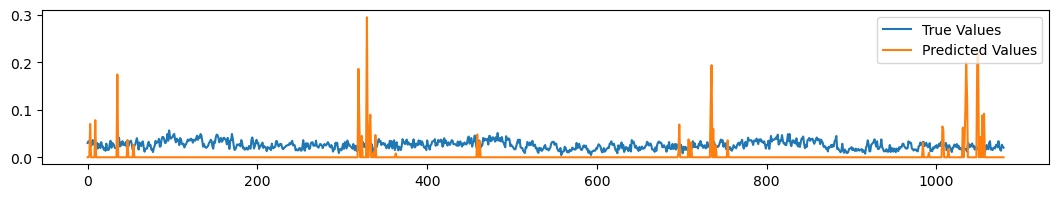

In [74]:
# Looking at the predictions vs true values for testing the model

plt.figure(figsize=(13, 2))
plt.plot(y_true, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend(loc='upper right')

In [75]:
testing_error_mse_Florida = mean_squared_error(y_true, y_pred)
print("MSE: ", testing_error_mse_Florida)

MSE:  0.0009979547
